<img style="float: left; margin: 30px 15px 15px 15px;" src="https://pngimage.net/wp-content/uploads/2018/06/logo-iteso-png-5.png" width="300" height="500" /> 
    
    
### <font color='navy'> Simulación de procesos financieros. 

**Nombres:** Rubén Hernández Guevara | Andrés Hernández Jiménez.

**Fecha:** 09 de Marzo del 2021.

**Expediente** : 717710 | 717895.
**Profesor:** Oscar David Jaramillo Zuluaga.
    
**Link Github**: https://github.com/Rub27182n/Proyecto-SPF.git
    
**Repositorio de Pruebas:** https://github.com/Rub27182n/Tests_Proyecto-SPF.git

# Proyecto TEMA-2

# <font color='midnightblue'> 1. Análisis y Simulación de Videos de Youtube

> En este proyecto, examinaremos a detalle y simularemos las variables más escenciales de un video de YouTube: Likes, Dislikes, Comments y Views para obtener los estadísticos más probables de un hipotético video.

# <font color='midnightblue'> 2 . Objetivos

> ###  <font color='midnightblue'> Generales
>> Consideramos como objetivo principal, el generar un modelo/función que permita simular los principales y característicos estadísticos de los videos de YouTube México; utilizando los máximos recursos  posibles aprendidos hasta el tema dos de la materia.
    
> ###  <font color='midnightblue'> Específicos
>> - Obtener la Función de Distribución de Probabilidad de cada estadístico.
>> - Simular cantidad de Likes, Dislikes, Comments y Views.
>> - Aplicar satisfactoriamente los temas vistos en clase.
>> - Encontrar propiedades estadísticas lo más parecidas posibles a los datos reales

# <font color='midnightblue'> 3.  Definición del Problema
    
> En este proyecto queremos plantear la idea de una compañía que opera con Data Science,  y que a través de una base de datos de videos de YouTube, le es posible obtener distribuciones de probabilidad y simular casos específicos de hipotéticos videos, a los cuales se pretende estimar su recibimiento (número de vistas, likes, dislikes y comentarios) en la plataforma. 
    
> Todos los datos que se utilizarán son datos reales de videos que han estado en la sección "Tendencias" en Youtube México. Con los 4 estadísticos previamente mencionados, se podrá obtener la información necesaria para evaluar las diferentes categorías de videos y su recibimiento en la plataforma a través de simulación Monte Carlo. Estos parámetros serán los nodos para trabajar específicamente y a través de estos se generarán datos que nos permiten cumplir con el objetivo central, examinar a detalle y simular las variables escenciales de un video de YouTube. 

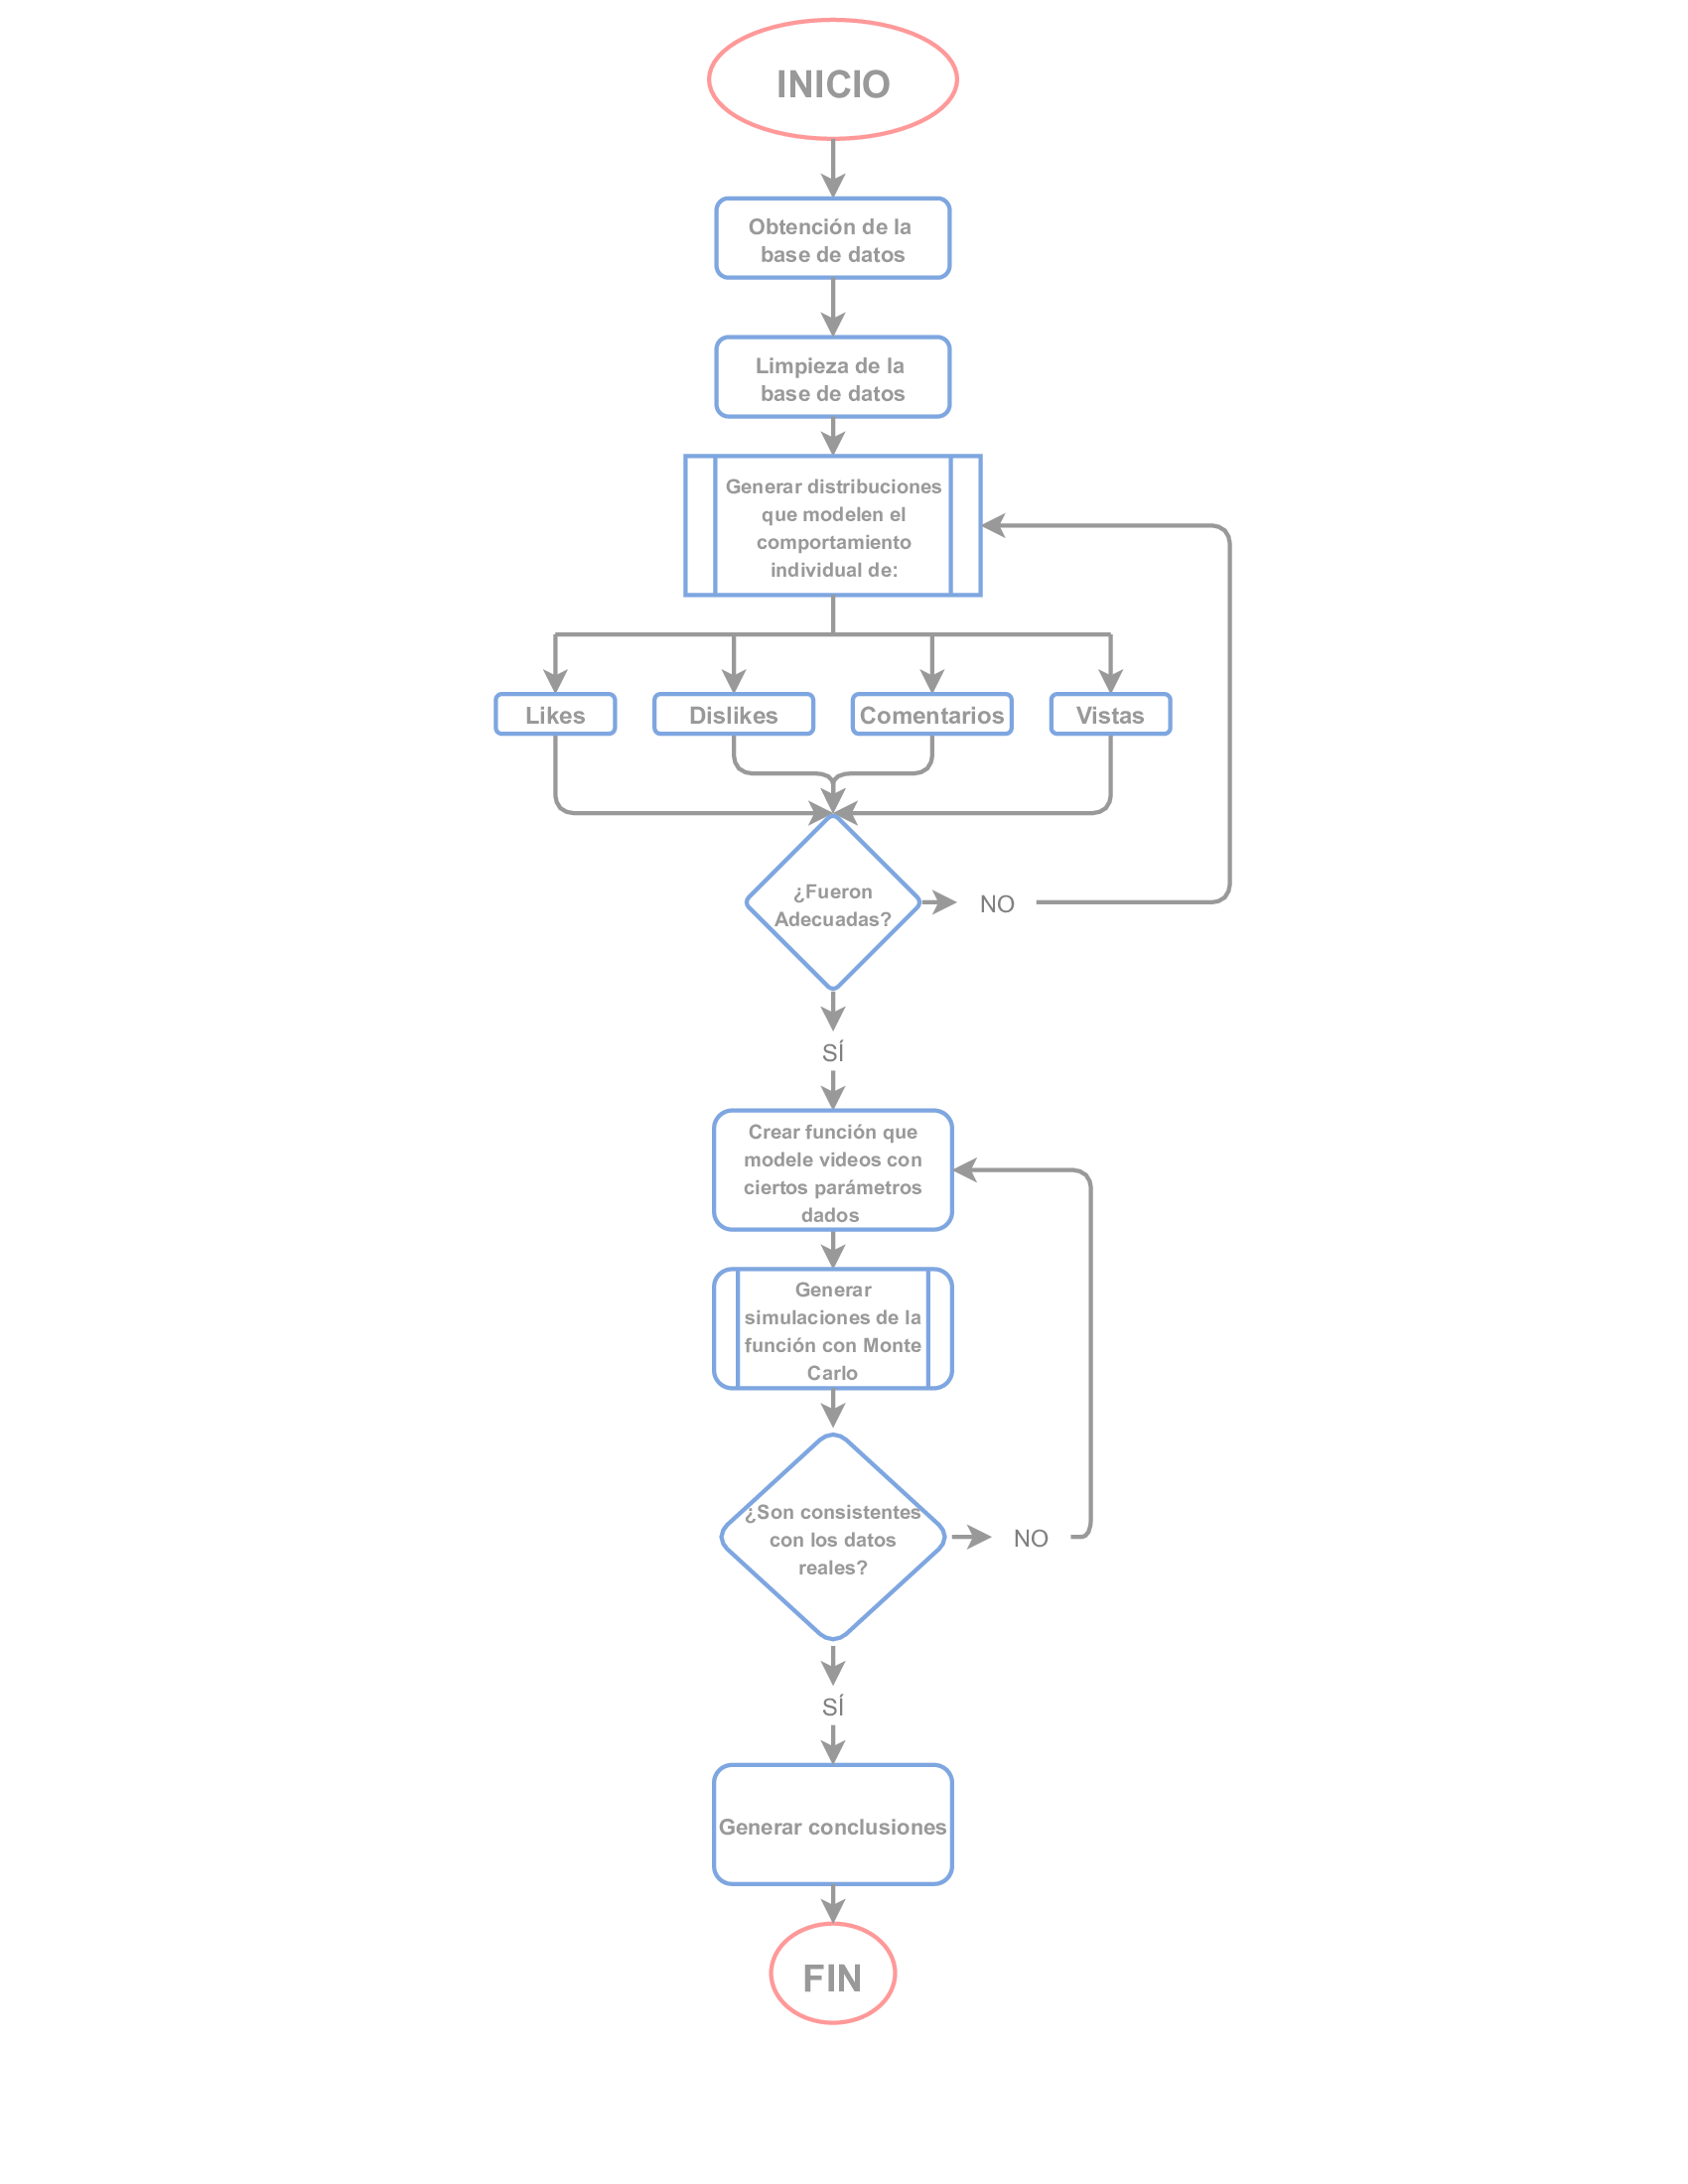

In [1]:
from IPython import display 
display.Image("./diagrama.png")

# <font color='midnightblue'> 4. Nodos/Variables a Simular

> Los nodos/variables que elegimos son:
> - Número de Vistas
> - Cantidad de Likes
> - Cantidad de Dislikes
> - Número de Comentarios

> Estos nodos fueron elegidos porque generamos la hipótesis de que intrínsecamente están correlacioandos y además se pueden simular ante el supuesto de un video ingresado en la red y su desempeño en la plataforma. La ratio entre likes y dislikes nos darán una muy buena idea de cómo se desempeña el video una vez en la plataforma. El número de vistas y sus respectivos comentarios afirmarán si este video está volviéndose popular.

# <font color='midnightblue'> 5. Definición de Hipótesis y Supuestos

> ###  <font color='midnightblue'> Hipótesis
>> Con base en la **Ley de los Grandes Números**, nuestra primer hipótesis es que a partir de una muestra de 20-30% de los datos, es posible generar Variables Aleatorias Distribuidas como X mejor distribución que se ajustan lo mejor posible a los datos reales.
    
>> La segunda, es que existe una cierta dependencia/correlación entre los nodos o variables que decidimos analizar, por lo que hacemos la suposición de que sus principales distribuciones aproximadas, serán muy parecidas.
    
> ###  <font color='midnightblue'> Supuestos
>> - La categoría del video no influye en los resultados del video.
>> - Los resultados de los videos no han sido modificados con algún tipo de bot/publicidad.
>> - Se tomará las 3 categorías con mayor frecuencia como las más populares.
    

# <font color='midnightblue'>6. Obtención de la Base de Datos

> Las bases de datos se obtuvieron directamente del sitio Kaggle, consta de un archivo .csv que contiene información sobre videos de YouTube México, esta información es representada en las siguientes categorías consideradas como las más importantes para este proyecto: 
- Número de Vistas
- Número de Comentarios
- Número de Likes
- Número de Dislikes
- Categoría de Video

> Enlace al dataset: [YouTube Video Statistics](https://www.kaggle.com/datasnaek/youtube-new)

# <font color='midnightblue'> Funciones y Librerías

In [2]:
import warnings
import numpy as np
import pandas as pd
from time import time
import seaborn as sns
import scipy.stats as st
from scipy import optimize
from IPython import display 
from CDIN import CDIN as eda
import statsmodels.api as sm 
import matplotlib.pyplot as plt
from fitter import Fitter as ft
from collections import Counter
from scipy.stats import gaussian_kde
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from statsmodels.nonparametric.kernel_density import KDEMultivariate

warnings.filterwarnings("ignore")

In [3]:
# -------------------- Función Para Obtener Histograma Junto con Distribuciones y su Respectivo Error --------------------
def distribuciones(data: 'datos',
                   dist: 'distribuciones',
                   b: 'bins'):  
    '''
    Función para probar distintas distribuciones,
    utiliza el Mean Squared Error
    ----------
    data: datos a ajustar
    dist: string o array de strings de distribuciones
    b: número de bins
    '''     
    global err, x, y, J 
    
    plt.figure(figsize = (16, 8))
    J = b    
    err = pd.DataFrame(index = dist, columns = ['MSE'])   
    y, x,  _ = plt.hist(data, bins = b, density = True)    
    x = x[1:]  #Para tener mismo shape en x, y
    
    def ajuste_dist(dist):
        global params
        params = getattr(st, dist).fit(data)
        y_hat = getattr(st, dist).pdf(x, *params)
        err.loc[dist] = ((y - y_hat)**2).mean()
        plt.plot(x, y_hat, label = dist);
    
    [ajuste_dist(dist) for dist in dist_list]
      
    plt.legend()
    plt.show()

In [4]:
# -------------------- Función Para Muestreo Estratificado --------------------
def Muestreo_Estratificado(n: 'n de V.A'):
    """
    Función para el método de muestreo estratificado,
    con el objetivo de aplicar métodos de reducción de varianza
    ----------
    n: Número de V a estratificar
    """
    U2 = np.random.rand(n)
    i = np.arange(0, n)
    me = (U2 + i) / n
    return me

In [5]:
# -------------------- Función Para Método de Aceptación y Rechazo --------------------
def MAR(N:'Número de V.A',
        f:'Función',
        g:'Función que Mayora a f',
        a:'Rango Inferior',
        b:'Rango Superior',       
        vae:'n V.A a Estratificar'):

    '''
    Regresa N variables aleatorias de la distribución f
    usando el método de aceptación y rechazo visto en clase
    aplicando a la vez un método de reducción de varianza 
    (Muestreo Estratificado)
    ----------
    N: Número de V.A a generar
    f: Función a trabajar
    g: Función que mayora a f
    a: Rango Inferior
    b: Rango Superior
    vae: n V.A a Estratificar
    '''    
    R2_x = Muestreo_Estratificado(vae)
    aceptados = 0
    j = 0
    x = np.zeros(N)
    
    
    while aceptados < N:
        R2 = R2_x[j]
        R1 = np.random.uniform(a, b)
        f_x = f(R1) 
        g_x = g(R1)
        condicion = R2 * g_x <= f_x
        [plt.plot(R1, R2*g_x, '.c') if condicion else plt.plot(R1, R2*g_x, '1')]           
        if condicion:
            x[aceptados] = R1
            aceptados += 1
        else:
            None
        j += 1
        if j == vae - 1:
            break
    plt.show()
    
    return x

In [6]:
# -------------------- Función Para Método Fitter --------------------
def fitter(data: 'datos',
           dist: 'distribuciones',
           t: 'interrupción', 
           b: 'bins'):
    '''
    Función para método fitter
    ----------
    data: datos a ajustar
    dist: string o array de strings de distribuciones
    t: tiempo hasta la interrupción de la prueba para la distribución en curso
    b: número de bins
    '''    
    global f
    f = ft(data, distributions = dist, timeout = t, bins = b)
    f.fit()

In [7]:
def random_gen(f:'Función',
               xx:'Linspace',
               data:'Datos',
               rv:'n Random Variables'):
    '''
    Función para generar V.A
    ----------
    f: Función a trabajar
    xx: Espacio en el eje x del histograma
    data: Datos
    rv: Número de V.A
    ''' 
    
    max_f = f(optimize.fmin(lambda x: -f(x), 5, disp = False))
    
    g = lambda x: max_f
    g_2 = lambda x: max_f*np.ones([len(x)])
    
    plt.plot(xx, f(xx), label = 't(x)')
    plt.plot(xx, g_2(xx), label = 't(x)')
    plt.legend(loc = 'best')
    
    random_values = MAR(rv, f, g, 0, np.max(data),  20000)
    random_values = random_values[random_values != 0]
    
    return random_values

In [8]:
# -------------------- Función Para Método Kolmogorov - Smirnov --------------------
def kol_smir_test(data: 'Datos',
                  dist: 'Distribuciones'):     
    '''
    Función para método Kolmogorov - Smirnov
    ----------
    data: Datos a ajustar
    dist: String o array de strings de distribuciones
    '''  
    param = getattr(st, dist).fit(data)   
    return st.kstest(data, dist, args = (param))

In [9]:
# -------------------- Función Para Método KDE Multivariate --------------------
def kde_statsmodels_m(x, x_grid, bandwidth=0.2, **kwargs):
    """Multivariate Kernel Density Estimation with Statsmodels"""
    kde = KDEMultivariate(x, 
                          bw='cv_ml',  
                          var_type='c', **kwargs)
    return lambda x: kde.pdf([x])

In [10]:
# -------------------- Función Histograma KDE --------------------
def KDE_f(data:'Datos',
             x:'Linspace',
             J:'Bins'):
    '''
    Función para crear histograma y figura de la posible función 
    que se ajusta a los datos
    ----------
    data: Datos a ajustar
    x: Espacio en el eje x del histograma
    J: Número de bins para el histograma
    '''
    f = kde_statsmodels_m(data, x)
    
    plt.hist(data, bins = J, density = True)
    plt.plot(x, f(x), label = 'Función f')
    plt.legend(loc = 'best')
    plt.show()
    
    return f

# <font color='midnightblue'> Limpieza del Dataset

In [11]:
mx = pd.read_csv('MXvideos.csv')
mx.shape

(40451, 16)

In [12]:
# ----------------------- Eliminar Columnas -----------------------
mx.drop(['trending_date', 'title', 'channel_title', 'publish_time', 'tags', 'thumbnail_link', 'comments_disabled', 'ratings_disabled', 'video_error_or_removed', 'description'], inplace=True, axis=1)

In [13]:
# ----------------------- Aplicar EDA (Exporatory Data Analysis) -----------------------
eda.dqr(mx)

,Nombre,data_types,missing_values,present_values,unique_values,min,max
video_id,video_id,object,0,40451,33513,#NAME?,zzxLG6R5cHI
category_id,category_id,int64,0,40451,16,1,43
views,views,int64,0,40451,35915,157,100912384
likes,likes,int64,0,40451,14564,0,4470923
dislikes,dislikes,int64,0,40451,3693,0,1353667
comment_count,comment_count,int64,0,40451,6310,0,905925


In [14]:
# ----------------------- Crear df sin 'video_id' repetidos -----------------------
df = mx[~mx.duplicated(subset = ['video_id'])]

In [15]:
# ----------------------- Identificar Columnas con Valores = 0 -----------------------
index_names = df[(df['likes'] == 0) | (df['dislikes'] == 0 ) | (df['comment_count'] == 0 )].index

In [16]:
# ----------------------- Eliminarlos -----------------------
df.drop(index_names, inplace = True)

In [17]:
# ----------------------- Tamaño Final del Dataset -----------------------
df.shape

(31965, 6)

In [18]:
# ----------------------- Aplicar ln a las Columnas -----------------------
df['views'] = np.log(df['views'])
df['likes'] = np.log(df['likes'])
df['dislikes'] = np.log(df['dislikes'])
df['comment_count'] = np.log(df['comment_count'])

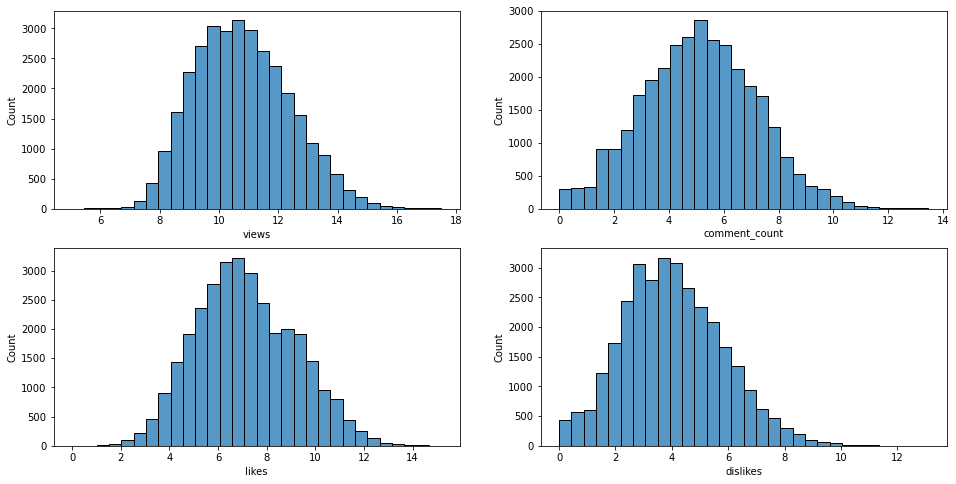

In [19]:
# ----------------------- Ver Forma de los Datos -----------------------
fig, ax = plt.subplots(2, 2, figsize=(16,8))

sns.histplot(df['views'], ax=ax[0,0], bins = 30)
sns.histplot(df['comment_count'], ax=ax[0,1], bins = 30)
sns.histplot(df['likes'], ax=ax[1,0], bins = 30)
sns.histplot(df['dislikes'], ax=ax[1,1], bins = 30);

# <font color='midnightblue'> Simulación nodo 1: Likes

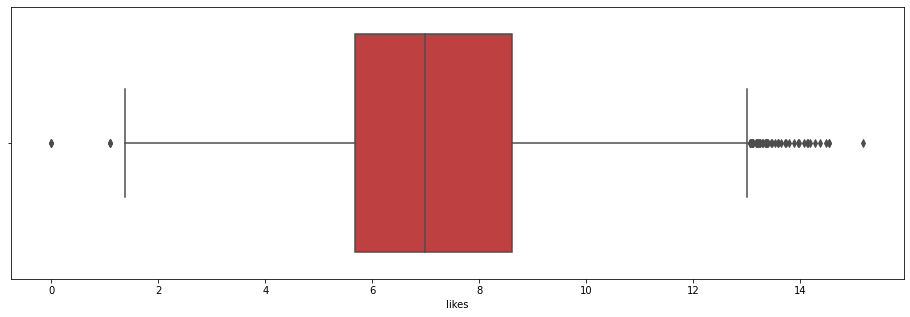

In [20]:
fig, ax1 = plt.subplots(figsize=(16, 5))
sns.boxplot(df['likes'], ax = ax1, saturation=.5, color='r', fliersize=5);

## <font color='midnightblue'> - Prueba con Función Creada

In [21]:
# -------------------- Distribuciones Seleccionadas Específicamente Para Este Nodo --------------------
dist_list = ['beta', 'chi', 'chi2', 'gengamma', 'nakagami', 'exponweib', 'norm', 'pearson3', 'genlogistic', 'exponnorm']

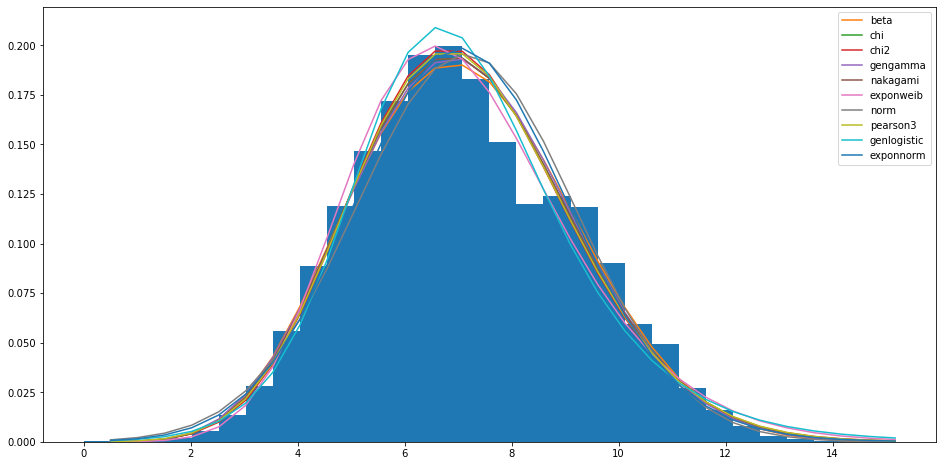

Wall time: 5.33 s


In [22]:
%%time
distribuciones(df['likes'], dist_list, 30)

In [23]:
# -------------------- Top Distribuciones Para 'Likes' --------------------
err.sort_values(by = 'MSE')

,MSE
beta,0.000112518
chi,0.000122472
nakagami,0.000122473
gengamma,0.000123077
pearson3,0.000128598
chi2,0.000133852
exponnorm,0.000134207
norm,0.00013607
exponweib,0.00018838
genlogistic,0.000201271


In [24]:
best = err.sort_values(by = 'MSE').head(3).index.values
best

array(['beta', 'chi', 'nakagami'], dtype=object)

## <font color='midnightblue'> - Prueba con Método Fitter

Wall time: 2.72 s


,sumsquare_error,aic,bic,kl_div
beta,0.002513,267.336106,-522862.271574,inf
exponweib,0.002542,253.318301,-522502.673805,inf
chi,0.002573,254.911685,-522114.705494,inf
nakagami,0.002573,254.911703,-522114.335464,inf
pearson3,0.002702,246.658946,-520555.369346,inf


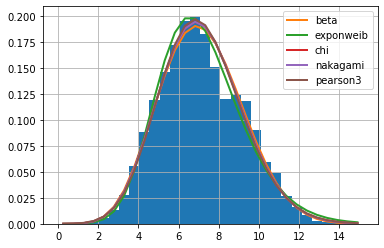

In [25]:
%%time
fitter(df['likes'], dist_list, 15, 30)
f.summary()

#### <font color='midnightblue'> Conclusión Para Distribuciones con la Función Creada y Método Fitter:
> Para ambos métodos se pude comprobar visualmente que las distribuciones elegidas se ajustan bien a nuestros datos, pero gracias al cálculo del error es que podemos elegir las mejores distribuciones: $Beta, Chi$ y $Nakagami$. Si bien la distribución exponweib tuvo un buen desempeño en el método fitter, en la función fue de las peores, mientras que Chi y Nakagami siguieron mostrando un error bajo en ambos métodos.
    
> Respecto al método Fitter, dejado para su estudio e implementación por nuestra cuenta, nos parece excelente ya que ahorra líneas y tiempo, aunque sean solo segundos, cuenta mucho.

## <font color='midnightblue'> - Prueba Q-Q Para la Distribución Beta

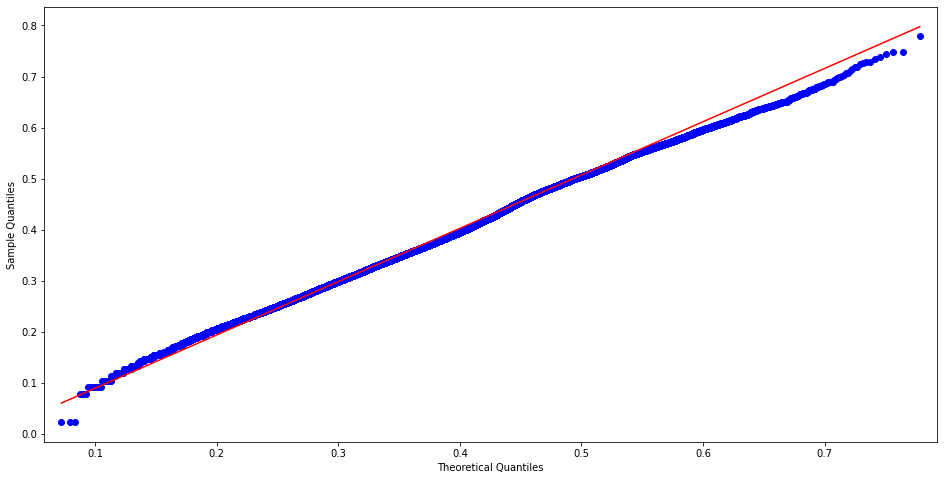

In [26]:
dist = best
fig, ax = plt.subplots(1,1, figsize = [16, 8])
g1 = sm.qqplot(df['likes'], dist = getattr(st, best[0]), line = 'q', fit = True, ax = ax)

> La mayor (no tan grande) incongruencia en la prueba Q-Q está en la cola derecha, visible también en el diagrama de caja. Es suficiente para negar o afirmar que la distribución es Beta? lo averiguaremos con la prueba $\chi^2$ y la prueba de Kolmogorov - Smirnov.

## <font color='midnightblue'> - Prueba de la Chi Cuadrada $\chi^2$ Para la Distribución Beta
    
#### <font color='midnightblue'> Hipótesis Nula $H_0$:
la distribución es Beta con "media= $\mu$" y "desviación estándar = $\sigma$"
#### <font color='midnightblue'> Hipótesis Alterna $H_a$:
La distribución no es Beta

In [27]:
mu = x.mean()
sigma = x.std()
param = getattr(st, 'beta').fit(x)

In [28]:
pi = st.beta.pdf(x, *param)
# Cálculo de la esperanza usando la expresión teórica
Ei = x*pi
# Cálculo usando la librería estadística de la chi cuadrada
Xs = st.chisquare(y, Ei)
print('Valor de chi cuadrado librería: ', Xs)

# Cálculo de Grados de libertad del estadístico
p = 3 # Parámetros estimados con los datos
m = J-p-1 # grados de libertad

Chi_est2 = st.chi2.ppf(q = 0.90, df = m)
print('Estadístico de chi_cuadrado = ', Chi_est2)
print('Media muestral: %f \nDesviación estándar muestral: %f '%(mu, sigma))
print('Media real: %f \nDesviación real: %f'%(df['likes'].mean(), df['likes'].std()))

Valor de chi cuadrado librería:  Power_divergenceResult(statistic=24.487759355991663, pvalue=0.7045336122326327)
Estadístico de chi_cuadrado =  35.563171271923466
Media muestral: 7.838557 
Desviación estándar muestral: 4.377172 
Media real: 7.140719 
Desviación real: 2.039275


#### <font color='midnightblue'> Conclusión Método Chi Cuadrada $\chi^2$:
> <font color='midnightblue'> El pvalue es suficientemente grande, y si es grande no se rechaza. Damos como válida la $H_0$

## <font color='midnightblue'> - Kolmogorov - Smirnov Para las Mejores 3 Distribuciones
#### <font color='midnightblue'>Fijamos un Nivel de Confianza de 99%. Entonces, si pvalue es menor a .01, el ajuste no será apropiado.
#### <font color='midnightblue'> Hipótesis Nulas $H_0$:

In [29]:
h0 = ['$H_0$ = La PDF es {}'.format(dist) for dist in best]
h0

['$H_0$ = La PDF es beta',
 '$H_0$ = La PDF es chi',
 '$H_0$ = La PDF es nakagami']

#### <font color='midnightblue'> Hipótesis Alternas $H_a$:

In [30]:
ha = ['$H_a$ = La PDF no es {}'.format(dist) for dist in best]
ha

['$H_a$ = La PDF no es beta',
 '$H_a$ = La PDF no es chi',
 '$H_a$ = La PDF no es nakagami']

In [81]:
nodo1 = np.random.choice(df['likes'], 3000)

In [82]:
top_kol_smir = [kol_smir_test(nodo1, dist) for dist in best]

In [83]:
top_kol_smir

[KstestResult(statistic=0.02086058670406893, pvalue=0.14483153890806144),
 KstestResult(statistic=0.03006449192517635, pvalue=0.008644510636623002),
 KstestResult(statistic=0.030064169268826713, pvalue=0.008645519153803728)]

### <font color='midnightblue'> Conclusión Método Kolmogorov - Smirnov:
> <font color='midnightblue'> Solo el pvalue de la Beta es mayor al nivel de significancia establecido, entonces solo aceptamos esa $H_0$. 

> <font color='midnightblue'> Además, el resultado es consistente con el top de distribuciones con menor error.

## <font color='midnightblue'> - Estimación de función para MAR con KDE

In [34]:
nodo1 = np.random.choice(df['likes'], 10000)

In [35]:
xg = np.linspace(0, np.max(df['likes']), 10000)

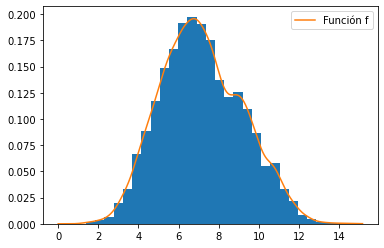

Wall time: 30.1 s


In [36]:
%%time
f = KDE_f(nodo1, xg, 30)

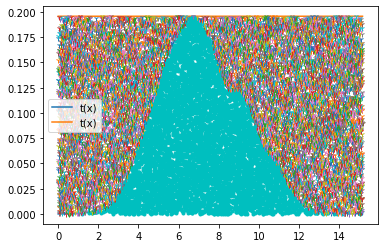

Wall time: 1min 6s


array([ 9.33686148, 15.05519182,  3.34138471, ...,  6.78637115,
        6.64873963,  6.76033023])

In [37]:
%%time
V_A_nodo1 = random_gen(f, xg, df['likes'], 25000)
V_A_nodo1

In [38]:
V_A_nodo1_exp = np.exp(V_A_nodo1)
V_A_nodo1_exp

array([1.13487341e+04, 3.45451221e+06, 2.82582292e+01, ...,
       8.85693671e+02, 7.71810946e+02, 8.62927116e+02])

## <font color='midnightblue'> - Intervalo de Confianza Para la Media de los Datos

In [40]:
# Intervalo de confianza usando t-student
i1 = st.t.interval(.95, len(V_A_nodo1_exp)-1, loc=np.mean(V_A_nodo1_exp), scale=st.sem(V_A_nodo1_exp))
# Intervalo de confianza usando distribución normal
i2 = st.norm.interval(.95, loc=np.mean(V_A_nodo1_exp), scale=st.sem(V_A_nodo1_exp))
print('Con una confianza de %2.2f la media estará en el intervalo t,\n %s     ' %(.95,i1))
print('Con una confianza de %2.2f la media estará en el intervalo normal,\n %s' %(.95,i2))
print('Media calculada' , np.mean(V_A_nodo1_exp))

Con una confianza de 0.95 la media estará en el intervalo t,
 (9018.484294896845, 11776.262389265017)     
Con una confianza de 0.95 la media estará en el intervalo normal,
 (9018.729801453333, 11776.016882708529)
Media calculada 10397.373342080931


In [41]:
np.mean(np.exp(df['likes']))

10180.517722508994

In [42]:
np.mean(V_A_nodo1_exp)

10397.373342080931

# <font color='midnightblue'> Simulación nodo 2: Views

In [43]:
datax=df['views']

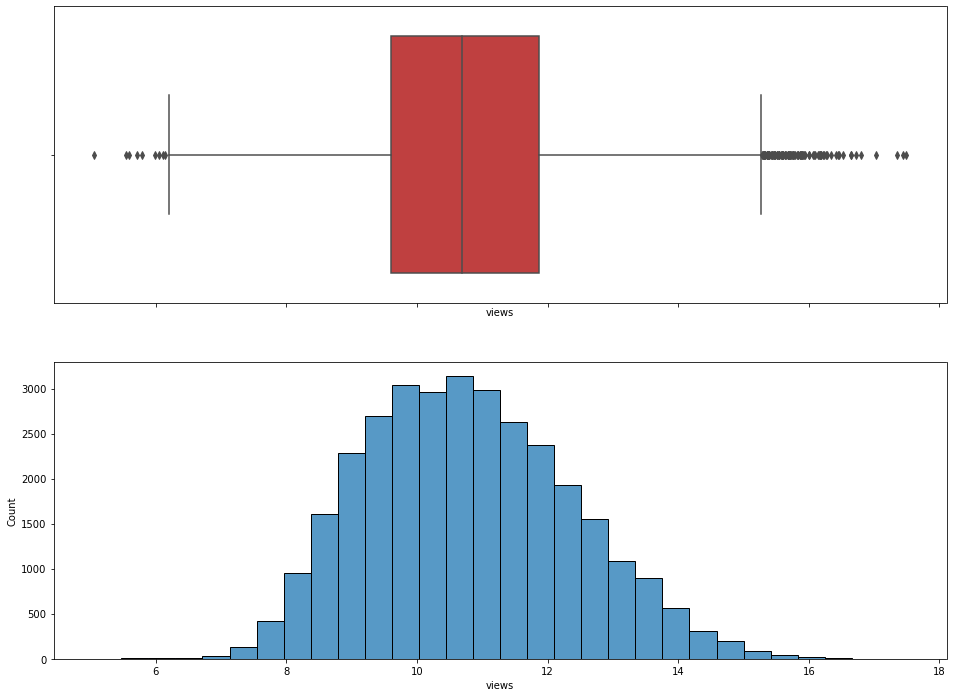

In [44]:
fig,(ax1, ax2) = plt.subplots(2, 1, sharex = True, figsize=(16, 12))
sns.histplot(datax, ax = ax2, bins = 30);
sns.boxplot(datax, ax = ax1, saturation =.5, color = 'r');

## <font color='midnightblue'> - Prueba con Función Creada

In [45]:
# -------------------- Distribuciones Seleccionadas Específicamente Para Este Nodo --------------------
dist_list = ['beta', 'burr12', 'chi', 'chi2', 'gengamma', 'logistic', 'nakagami', 'norm', 'pearson3']

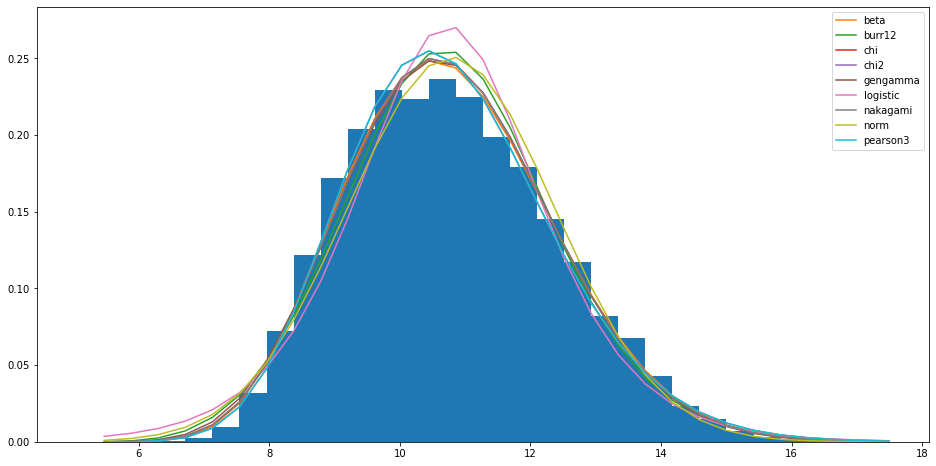

Wall time: 5.35 s


In [46]:
%%time
distribuciones(datax, dist_list, 30)

In [47]:
# -------------------- Top  Distribuciones Para 'Views' --------------------
err.sort_values(by = 'MSE')

,MSE
beta,0.00011859
nakagami,0.000125395
chi,0.000125397
gengamma,0.00013107
norm,0.000149394
chi2,0.000170776
pearson3,0.000170826
burr12,0.000174962
logistic,0.000336402


In [48]:
best = err.sort_values(by = 'MSE').head(3).index.values
best

array(['beta', 'nakagami', 'chi'], dtype=object)

## <font color='midnightblue'> - Prueba con Método Fitter

Wall time: 2.26 s


,sumsquare_error,aic,bic,kl_div
beta,0.001951,274.958146,-530950.172316,0.004781
nakagami,0.002452,266.144340,-523658.173236,0.006249
chi,0.002452,266.146171,-523658.000810,0.006249
pearson3,0.002509,257.154202,-522927.437514,0.006408
chi2,0.002509,257.149496,-522922.947137,0.006408


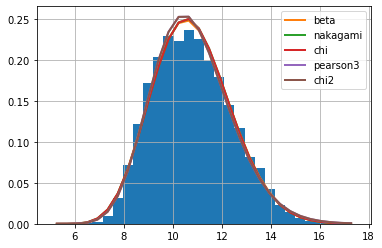

In [49]:
%%time
fitter(datax, dist_list, 15, 30)
f.summary()

#### <font color='midnightblue'> Conclusión Para Distribuciones con la Función y Método Fitter:
> Gracias a este método se puede comprobar el error en las distintas distribuciones de un método diferente, a diferencia de los otros métodos que también nos permiten ver esto de forma visual. En el caso del nodo para las "Views" apreciamos que las distribuciones $Gengamma, Beta$ y $Chi$ son las que mejor se ajustan y se mantienen constantes en ambos métodos a diferencias de distribuciones como la $Norm$ la cual con este metodo no tuvo lugar.  

## <font color='midnightblue'> - Prueba Q-Q Para la Distribución Beta

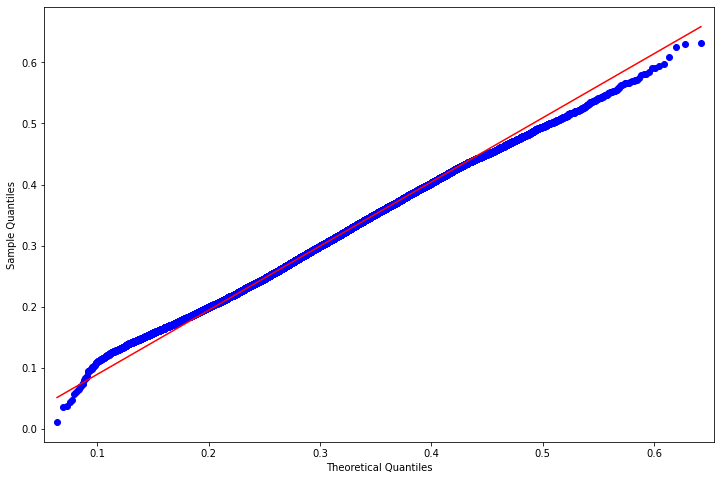

In [50]:
dist = best
fig, ax = plt.subplots(1,1, figsize = [12, 8])
g1 = sm.qqplot(datax, dist = getattr(st, best[0]), line = 'q', fit = True, ax = ax)

> Se puede apreciar una incongruencia en la prueba Q-Q en la parte derecha de la cola.

## <font color='midnightblue'> Prueba de la Chi Cuadrada $\chi^2$ Para la Distribución Beta

#### <font color='midnightblue'> Hipótesis Nula $H_0$:

<font color='midnightblue'> La distribución es Beta

#### <font color='midnightblue'> Hipótesis Alterna $H_a$:

<font color='midnightblue'> La distribución no es Beta

In [51]:
# Media y desviación estándar muestral
mu = np.mean(datax)
sigma = np.std(datax)
print('media mu =%f, desviación estándar muestral =%f'%(mu,sigma))

media mu =10.784820, desviación estándar muestral =1.589812


In [52]:
param = getattr(st,'beta').fit(datax)
param

(9.660335244421159, 22.77961534952012, 4.82187055637174, 20.035238452334276)

In [53]:
pi = st.beta.pdf(x, *param)

# Cálculo de la esperanza usando la expresión teórica
Ei = x*pi
#J= 30
# Cálculo teórico de la chi cuadrada
x2 = np.sum(list(map(lambda Ei, obs_i:(obs_i - Ei)**2 / Ei, Ei, y)))
print('Valor de chi cuadrado teorico  = ', x2)

# Cálculo usando la librería estadística de la chi cuadrada
Xs = st.chisquare(y, Ei)
print('Valor de chi cuadrado librería = ', Xs)

# Cálculo de Grados de libertad del estadístico
p = 3 # Parámetros estimados con los datos
m = J-p-1 # grados de libertad

Chi_est = st.chi2.ppf(q=0.95, df=m)
print('Estadístico de chi_cuadrado = ', Chi_est)
print('Media muestral = ', mu, '\nDesviación estándar muestral = ', sigma)
print('Media real: %f \nDesviación real muestral: %f'%(datax.mean(), datax.std()))

Valor de chi cuadrado teorico  =  21.433071503179352
Valor de chi cuadrado librería =  Power_divergenceResult(statistic=21.433071503179352, pvalue=0.842889744164425)
Estadístico de chi_cuadrado =  38.885138659830055
Media muestral =  10.784820284165825 
Desviación estándar muestral =  1.5898122728953406
Media real: 10.784820 
Desviación real muestral: 1.589837


#### <font color='midnightblue'> Conclusión Método Chi Cuadrada $\chi^2$:
> <font color='midnightblue'> Debido a ue el p-value es lo suficientemente grande este no se rechaza. Por lo tanto se acepta la $H_0$

## <font color='midnightblue'> - Kolmogorov - Smirnov Para las Mejores 3 Distribuciones
#### <font color='midnightblue'>Fijamos un Nivel de Confianza de 99%. Entonces, si pvalue es menor a .01, el ajuste no será apropiado.
#### <font color='midnightblue'> Hipótesis Nulas $H_0$:

In [54]:
h0 = ['$H_0$ = La PDF es {}'.format(dist) for dist in best]
h0

['$H_0$ = La PDF es beta',
 '$H_0$ = La PDF es nakagami',
 '$H_0$ = La PDF es chi']

#### <font color='midnightblue'> Hipótesis Alternas $H_a$:

In [55]:
ha = ['$H_a$ = La PDF no es {}'.format(dist) for dist in best]
ha

['$H_a$ = La PDF no es beta',
 '$H_a$ = La PDF no es nakagami',
 '$H_a$ = La PDF no es chi']

In [56]:
nodo2 = np.random.choice(df['views'], 6000)

In [57]:
top_kol_smir = [kol_smir_test(nodo2, dist) for dist in best]

In [58]:
top_kol_smir

[KstestResult(statistic=0.01456590076977271, pvalue=0.1551996932647216),
 KstestResult(statistic=0.01685969767972889, pvalue=0.06527082702176468),
 KstestResult(statistic=0.016859918164392362, pvalue=0.06526499457742319)]

### <font color='midnightblue'> De acuerdo con el P-value siendo mayor al nivel de significancia se pueden aceptar las tres Hipótesis Nulas $H_0$ confirmando que la mejor distribución del nodo Views es en $beta$:

## <font color='midnightblue'> - Estimación de función para MDAR con KDE

In [59]:
xg = np.linspace(0, np.max(datax), 6000)

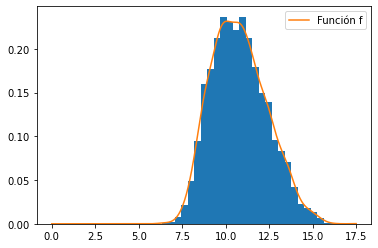

Wall time: 10.2 s


In [60]:
%%time
f = KDE_f(nodo2, xg, 30)

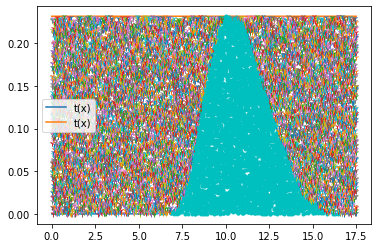

Wall time: 1min 3s


array([ 7.20263315,  8.78205152,  7.02884501, ..., 10.01365445,
       10.01418394,  9.99381637])

In [68]:
%%time
V_A_nodo2 = random_gen(f, xg, datax, 25000)
V_A_nodo2

In [70]:
V_A_nodo2_exp = np.exp(V_A_nodo2)
V_A_nodo2_exp

array([ 1342.96232907,  6516.23167593,  1128.72619512, ...,
       22329.28776359, 22341.11413729, 21890.68255543])

## <font color='midnightblue'> - Intervalo de Confianza Para la Media de los Datos

In [71]:
# Intervalo de confianza usando t-student
i1 = st.t.interval(.95, len(V_A_nodo2_exp)-1, loc=np.mean(V_A_nodo2_exp), scale=st.sem(V_A_nodo2_exp))
# Intervalo de confianza usando distribución normal
i2 = st.norm.interval(.95, loc=np.mean(V_A_nodo2_exp), scale=st.sem(V_A_nodo2_exp))
print('Con una confianza de %2.2f la media estará en el intervalo t,\n %s     ' %(.95,i1))
print('Con una confianza de %2.2f la media estará en el intervalo normal,\n %s' %(.95,i2))
print('Media calculada' , np.mean(V_A_nodo2_exp))

Con una confianza de 0.95 la media estará en el intervalo t,
 (175087.14245846798, 205783.8854178476)     
Con una confianza de 0.95 la media estará en el intervalo normal,
 (175090.84675570566, 205780.18112060992)
Media calculada 190435.5139381578


In [65]:
# Media Real
np.mean(np.exp(datax))

191844.04464257782

In [72]:
# Media de Variables Simuladas
np.mean(V_A_nodo2_exp)

190435.5139381578

# <font color='midnightblue'> ANEXOS

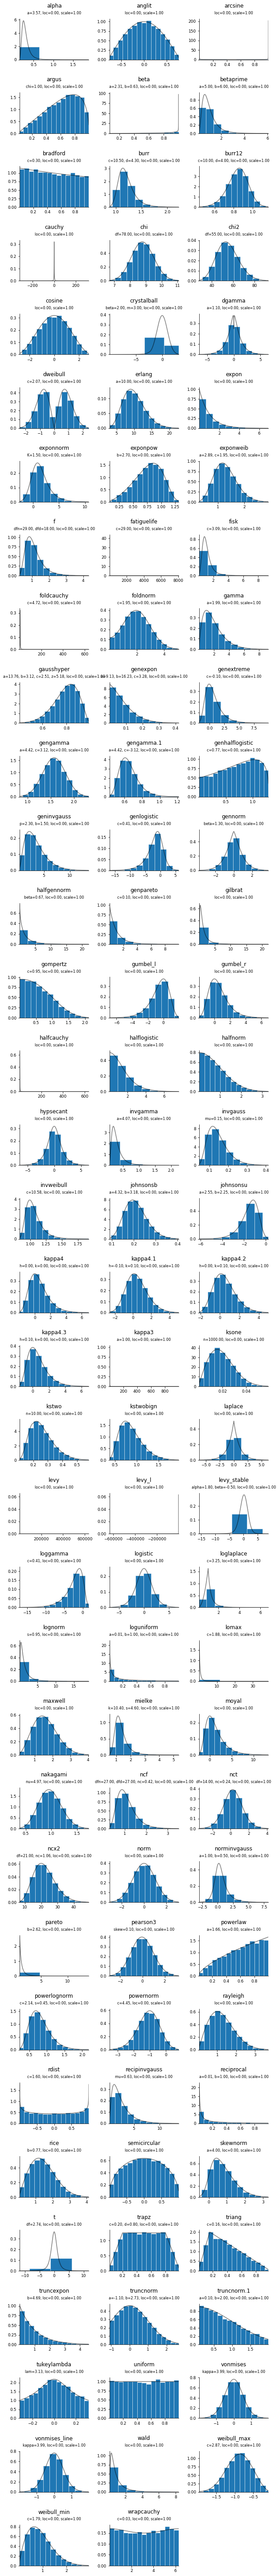

In [67]:
# ----------------------- Imagen de Distribuciones Continuas -----------------------
display.Image("./Distribuciones.png")

## <font color='midnightblue'> Fuentes Consultadas
> https://fitter.readthedocs.io/en/latest/index.html
    
> https://www.statology.org/kolmogorov-smirnov-test-python/
    
>
    
>
    
>
    
>
    
>
    
>
    
>
    
>
    